# Homework 4, Part 2

In Part 1, we saw how to create a bi-encoder to estimate the relevance of a query-document pair and generate these relevance scores. In Part 2, we'll see how to integrate those scores into a learning to rank (L2R) model with a few features.

For this part, you are going to:
1. Create the dataset ready to use for Pyterrier.
2. integrate the cosine similarity you have got in part 1 into the features of learning to rank models.


Learning goals for Homework 4, Part 2:
* Improve familiarity with installing and running Pyterrier code
* Learn how to use L2R models in Pyterrier
* Learn how to add custom features to L2R models with Pyterrier.
* Deepen your understanding of how different models perform in mixed-domain settings (e.g., text queries / code docs)


### Step 0: install things as needed

In case you didn't do any of Homework 3 (which was extra credit), please be sure to have the following libraries installed and ready. The installation command is commented out for now but uncomment and run each as needed.

In [1]:
# !pip install fastrank
# !pip install lightgbm

# Task 1: Creating a dataset with precomputed features

## Task 1.1

Load in the dataset used for evaluation as a pandas data frame, which is in `final_evaluation_set.csv`. Then print the number of unique queries (99), unique code-documents in the dataset (958) to verify it was loaded correctly.

In [2]:
import pandas as pd
import numpy as np

In [3]:
# TODO
fes = pd.read_csv("data/final_evaluation_set.csv")
print(len(fes['Query'].unique()))
print(len(fes['GitHubUrl'].unique()))

99
958


## Task 1.2: Creating an index  (5 points)

Since the code documents are text, we can still create an index to store them (just like regular documents before). Before, we mostly used pre-built indices or loaded them from file. In this part, you'll see how to create your own index from a pandas dataframe. 

The rough steps are as follows:
* Start pyterrier
* Map each unique code document to a unique string identifier (keep this around in a dictionary!)
* Create a pandas DataFrame of each unique code-document with two columns:
  * `text` containing the contents of the code-document 
  * `docid` a unique string identifier for that code-document
* use pyterrier's [`DFIndexer`](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html) to create an index from the data frame.

Once you're finished with these steps, print the collection statistics, which should look something like this:
```
Number of documents: 958
Number of terms: 4929
Number of postings: 26358
Number of fields: 0
Number of tokens: 65017
Field names: []
Positions:   false
```

In [4]:
# TODO: Set this based on where Java is installed
# !export JAVA_HOME=/usr/lib/jvm/java-18-openjdk-amd64/

In [5]:
# TODO
# Start pyterrier
import os
import pyterrier as pt

if not pt.started():
    pt.init(tqdm='notebook')

PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [6]:
# Map each unique code document to a unique string identifier (keep this around in a dictionary!)
ucd_dict = {}
ucd_list = list(fes['GitHubUrl'].unique())
i = 0
for ucd in ucd_list:
    ucd_dict[ucd] = 'd' + str(i)
    i = i+1

In [7]:
# Create a pandas DataFrame of each unique code-document with two columns 'text' and 'docno'
fes_uni = fes.drop_duplicates('GitHubUrl')[['GitHubUrl','code']].rename(columns = {'code':'text'})
fes_uni_docid = []
for i in range(len(fes_uni)):
    fes_uni_docid.append(ucd_dict[fes_uni.iloc[i]['GitHubUrl']])
fes_uni['docno'] = fes_uni_docid

In [8]:
# use pyterrier's DFIndexer to create an index from the data frame
index_dir = './code_index'
indexer = pt.DFIndexer(index_dir, overwrite=True)
index_ref = indexer.index(fes_uni["text"], fes_uni["docno"])
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

Number of documents: 958
Number of terms: 4929
Number of postings: 26358
Number of fields: 0
Number of tokens: 65017
Field names: []
Positions:   false



## Task 1.3: Preparing the query data

We'll be using Pyterrier's `Experiment` framework to do our evaluation so we'll need to organize our queries in the test set into a pandas `DataFrame`. Create a new dataframe for all unique queries with two columns:
* `query` the text of the query
* `qid` a unique string identifier for that query

In [9]:
# TODO
queries = fes[['Query']].drop_duplicates()
queries['qid'] = np.arange(0,99)
queries['qid'] = queries['qid'].astype(str)
queries = queries.rename(columns = {'Query':'query'})
queries.head()

,query,qid
0,write csv,0
10,unzipping large files,1
20,unique elements,2
30,underline text in label widget,3
40,string to date,4


## Task 1.4: Preparing the Evaluation data

In the final step, we'll create a single data frame that contains the queries, documents, and true relevance scores, which we'll use to evaluate our models using `pt.Experiment`. Your dataframe should have three columns:
* `qid` the unique string identifier for a query
* `docno` the unique string identifier for a code-document
* `label` the relevance score for that query-document pair

In [10]:
# TODO
qrels = pd.merge(queries, fes, left_on = 'query', right_on = 'Query')
qrels = pd.merge(qrels[['qid','code','relevance']], fes_uni, left_on ='code',right_on = 'text')
qrels = qrels[['qid','docno','relevance']].rename(columns = {'relevance':'label'}).drop_duplicates()
qrels['qid'] = qrels['qid'].astype(str)
qrels.head()

,qid,docno,label
0,0,d0,3
1,0,d1,3
2,0,d2,3
3,0,d3,3
4,0,d4,3


# Task 2: Learning to Rank

The steps in Task 2 will have you running some evaluations and setting up a Learning to Rank model that we'll extend later to incorporate the bi-encoder features.

First, we'll split our labeled query-document data into train, development, and test sets so we can train models and evaluate unsupervised models.

In [11]:
# there are some characters in the query have a special meaning in the Terrier query language. 
# strip them out using the Tokeniser
def strip_markup(text):
    tokeniser = pt.autoclass("org.terrier.indexing.tokenisation.Tokeniser").getTokeniser()
    return " ".join(tokeniser.getTokens(text))

queries =  pt.apply.query(lambda r: strip_markup(r.query))(queries)
queries = queries[['query','qid']]

In [12]:
SEED=42
from sklearn.model_selection import train_test_split
tr_va_topics, test_topics = train_test_split(queries, test_size=30, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=10, random_state=SEED)

## Task 3.1: Test baseline models (5 points)

In this initial step, create two `BatchRetrieve` rankers that use "BM25" or "TF_IDF" and run an `pt.Experiment` using them on the code index, using "map" and "ndcg" to evaluate their performance. We'll evaluate these only on the test data (no hyperparameter fine-tuning).

In [13]:
# TODO
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")

pt.Experiment(
    [bm25,tf_idf],
    test_topics,
    qrels,
    names=['BM25','TF-IDF'],
    eval_metrics=["map", "ndcg"]
)

,name,map,ndcg
0,BM25,0.778419,0.825697
1,TF-IDF,0.778695,0.829723


## Task 3.2: Creating our first pipeline (10 points)

Let's start getting more complex with our pipelines. Create a feature pipeline that has three features:
1.   the BM25 code score;
2.   the TF-IDF code score;
3.   the coordinate match score for the query--i.e. how many query terms appear in the code;

We'll use these features later in learning to rank. Fo

In [14]:
# TODO
ltr_feats1 = bm25 >> (
    pt.transformer.IdentityTransformer()
    ** # tf-idf
    tf_idf
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch") 
)

# for reference, lets record the feature names here too
fnames=["BM25", "TF-IDF", "CoordinateMatch"]

## Setting up the Learning to Rank (L2R) models

For the next part, you won't need to write any code (we've done it for you) but you will need to run the cells to train a few different kinds of L2R models on the training set. Each of the models captures a different kind of L2R that we talked about.

Train the following three models on our training set:
 - random forests from `scikit-learn`, a pointwise regression tree technique
 - coordinate ascent from FastRank, a listwise linear technique
 - LambdaMART from LightGBM, a listwise regression tree technique

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, qrels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s


CPU times: user 4.69 s, sys: 153 ms, total: 4.85 s
Wall time: 3.17 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    1.6s finished


In [16]:
import fastrank
train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, qrels)

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #2/5...
[+] Random restart #3/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
   1|2         

In [17]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[20]})

%time lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 8303, number of used features: 3
[Lig

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


## Task 3.4: Comparing L2R performance (10 points)

Now that we have all of our models, let's compare them with the baselines we had before. Run another `Experiment` that compare the three L2R models with the two baselines (BM25 and tf-idf). This time, we'll add "ndcg_cut_10" to see their performance on just the top 10 docs and "mrt" to see how fast the models are.

In [18]:
# TODO
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe,bm25, tf_idf], 
    test_topics,
    qrels,
    names=["fastrank",  "random forest", "LambdaMart", "bm25",'tf-idf'],
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"]
)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


,name,map,ndcg,ndcg_cut_10,mrt
0,fastrank,0.790156,0.839688,0.756826,22.880874
1,random forest,0.687240,0.783316,0.668496,30.115269
2,LambdaMart,0.685549,0.727322,0.614833,22.623268
3,bm25,0.778419,0.825697,0.744078,3.882451
4,tf-idf,0.778695,0.829723,0.746016,3.657715


# Task 4: Incorporating new features

We didn't expect those approaches to do too well since queries might not reflect the content in the code-documents. But our bi-encoder model knows how to compare both! In Task 4's steps, you'll incorporate it's relevance predictions into the model as another feature.

**Note**: For your course projects, if you use Pyterrier, this code should give you some idea of how to incorporate ranking features (or other information) that you've calculated from elsewhere.

## Task 4.1 Loading in the precomputed relevance data

Read in the dataframe with the bi-encoder's estimated relevance scores for each query-document pair (i.e., its cosine similarity), which we produced in Part 1. The length of the dataframe should be (number of unique query) * (number of unique documents).

In [19]:
# TODO
prd = pd.read_csv('data/relevance_scores.csv').drop(columns = ['Unnamed: 0']).iloc[:, 2:].rename(columns = {"Query_id": "qid",'Doc_id':'docno'})
prd['qid'] = prd['qid'].astype(str)
prd['docno'] = 'd'+(prd['docno'].astype(str))

prd.head()

,qid,docno,sim
0,0,d0,0.934156
1,0,d1,0.938960
2,0,d2,0.933673
3,0,d3,0.897763
4,0,d4,0.938280


## Task 4.2: Adding new features (10 points)

Once we have our bi-encoder estimates, we'll create a new pipeline that adds the score as a new feature. Recall that Pyterrier's [Pipeline](https://pyterrier.readthedocs.io/en/latest/pipeline_examples.html) is a transformation on a pandas `DataFrame` object. For us, that means we can write a function that operates on each row of the data frame and use pyterrier's [`apply`](https://pyterrier.readthedocs.io/en/latest/apply.html) (which is much like panda's [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)). Specifically, we'll write some code that for a given row with a document and query, looks up the precomputed relevance score.

While there's many ways to do this, your steps should probably look something like this:
* Create some data structure that can map a tuple of the query id and document id to the bi-encoder's relevance score
* Write a function takes in a row from a `DataFrame` and uses the query id and document id in the row's columns to look up the bi-encoder's relevance.
* Copy and extend your earlier pipeline by adding one new feature that uses pyterrier's `apply` function with your new function. Call this new pipeline `bienc_ltr_feats` so the later training functions can use it

Once you have this pipeline in place, use the code below to retrain the models. 

Add the feature of cosine similarity between query and code embedding into the feaure pipeline. Train the three models and run the experiements again.

In [20]:
# TODO
sim_dict = {}
for index, row in prd.iterrows():
    sim_dict[(row.qid,row.docno)] = row.sim

In [21]:
def find_relevance(row,sim_dict):
    # row is the iterator of dataframe
    return sim_dict[(row.qid,row.docno)]

In [22]:
index = pt.IndexFactory.of(index_ref)

In [23]:
bienc_ltr_feats = bm25 >> (
    pt.transformer.IdentityTransformer()
    ** # tf-idf
    tf_idf
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
    ** # bi-encoder's relevance
    (pt.apply.doc_score(lambda row: find_relevance(row,sim_dict)))
)


In [24]:
rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe = bienc_ltr_feats >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_topics, qrels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    2.3s finished


In [25]:
train_request = fastrank.TrainRequest.coordinate_ascent()
params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567
ca_pipe = bienc_ltr_feats >> pt.ltr.apply_learned_model(train_request, form='fastrank')
ca_pipe.fit(train_topics, qrels)

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
   1|3         

   0|2               |   -0.000|    0.844
   0|2               |   -0.000|    0.844
---------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
   0|2               |   -0.002|    0.844
   0|2               |   -0.004|    0.844
   0|2               |   -0.034|    0.844
   0|2               |   -0.068|    0.845
---------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
   0|0               |    0.000|    0.845
   0|0               |    0.001|    0.845
   0|0               |   -0.001|    0.846
   0|0               |   -0.002|    0.846
   4|3               |    0.541|    0.844
---------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
------------------------------

In [26]:
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 8303, number of used features: 3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_wei

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


## Task 4.3 Re-run the experiment here using the new features! (10 points)

In [27]:
# TODO
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe,bm25], 
    test_topics,
    qrels,
    names=["fastrank",  "random forest", "LambdaMart", "bm25"],
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"]
)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


,name,map,ndcg,ndcg_cut_10,mrt
0,fastrank,0.818955,0.855715,0.790695,30.655216
1,random forest,0.758528,0.823676,0.728540,33.603868
2,LambdaMart,0.685549,0.727322,0.614833,22.535864
3,bm25,0.778419,0.825697,0.744078,5.761557


# _Optional_: Evaluating the different models (20 points total; this is part 2)

How much training does the model actually need to recognize relevance? Would one epoch be enough? What if we did 10? or 100? (100 might be too many for Great Lakes limits...). In this **optional part**, we'll describe a series of steps you can take to explore this part!
 
The instructions in Part 1 had you update that notebook to save the model after each epoch and then generate relevance predictions for each, saving those to a file. In Part 2, we'll load those files and compare the performance:
 
Here's what you need to do:
* Using the code from the blocks above, create new version of the test data DataFrame that have predictions from each trained bi-encoder model. (i.e., you should have predictions from the model trained on one epoch worth of data, predictions from the model trained on two epochs, etc.)
* Retrain each L2R model using each of these new features, using just one feature at a time. This should give you (number of L2R models) * (number of different-epoch-trained-biencoder-models) worth of results.
* Create a line plot where
  * the x-axis is the number of epochs the bi-encoder model was trained
  * the y-axis is NDCG_cut_10
  * there are different lines for each L2R model (with different colors/hues for each model)
 
This plot should show you how much the bi-encoder's training time influences the scores. Compare that with the F1 performance plot you produced for Part 1. Does increasing F1 performance lead to increasing NDCG@10? How many epochs do you think you need to train to maximize performance?

**TODO:** For full credit, submit a separate doc/pdf with the plots from Parts 1 and 2 and a short paragraph describing your observations on the performance (see the questions above).

In [28]:
re = {}
for i in range(0, 5):
    prd = pd.read_csv('data/test_relevance_{}.csv'.format(i)).drop(columns = ['Unnamed: 0'])
    prd['qid'] = prd['qid'].astype(str)
    prd['docno'] = 'd'+(prd['docno'].astype(str))

    sim_dict = {}
    for index, row in prd.iterrows():
        sim_dict[(row.qid,row.docno)] = row.sim

    
    index = pt.IndexFactory.of(index_ref)
    bienc_ltr_feats = bm25 >> (
        pt.transformer.IdentityTransformer()
        ** # tf-idf
        tf_idf
        ** # abstract coordinate match
        pt.BatchRetrieve(index, wmodel="CoordinateMatch")
        ** # bi-encoder's relevance
        (pt.apply.doc_score(lambda row: find_relevance(row,sim_dict)))
    )

    # rf
    rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
    rf_pipe = bienc_ltr_feats >> pt.ltr.apply_learned_model(rf)
    rf_pipe.fit(train_topics, qrels)

    # ca
    train_request = fastrank.TrainRequest.coordinate_ascent()
    params = train_request.params
    params.init_random = True
    params.normalize = True
    params.seed = 1234567
    ca_pipe = bienc_ltr_feats >> pt.ltr.apply_learned_model(train_request, form='fastrank')
    ca_pipe.fit(train_topics, qrels)

    #lmart
    lmart_l = lgb.LGBMRanker(
        task="train",
        silent=False,
        min_data_in_leaf=1,
        min_sum_hessian_in_leaf=1,
        max_bin=255,
        num_leaves=31,
        objective="lambdarank",
        metric="ndcg",
        ndcg_eval_at=[10],
        ndcg_at=[10],
        eval_at=[10],
        learning_rate= .1,
        importance_type="gain",
        num_iterations=100,
        early_stopping_rounds=5
    )
    lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

    temp_table = pt.Experiment(
        [ca_pipe, rf_pipe, lmart_x_pipe,bm25], 
        test_topics,
        qrels,
        names=["fastrank",  "random forest", "LambdaMart", "bm25"],
        eval_metrics=["ndcg_cut_10"]
    )
    temp_table = pd.DataFrame(temp_table.values.T,columns = temp_table.name,index = temp_table.columns).iloc[1:,:]
    temp_table = pd.melt(temp_table,value_vars=['fastrank','random forest','LambdaMart'],var_name=['L2R models'])
    temp_table['epoch'] = [i+1]*3
    re[i] = temp_table

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    2.2s finished


---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
   2|3         

   0|0               |    0.000|    0.806
   0|0               |    0.000|    0.806
   0|0               |    0.000|    0.806
   0|0               |    0.001|    0.807
   0|2               |   -0.039|    0.807
   0|2               |   -0.035|    0.807
   1|0               |   -0.010|    0.813
   1|0               |   -0.009|    0.813
---------------------------
Finished successfully.


/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 8303, number of used features: 3
[Lig

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    2.5s finished


---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #4/5...
[+] Random restart #2/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
   4|3         

   0|2               |    0.000|    0.804
   0|2               |   -0.009|    0.804
   0|2               |   -0.047|    0.804
   0|2               |   -0.098|    0.804
---------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
   0|2               |   -0.199|    0.804
   0|2               |   -0.403|    0.806
   1|3               |    0.084|    0.813
   0|2               |   -0.810|    0.811
---------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
   0|0               |    0.000|    0.811
   0|0               |    0.003|    0.811
   0|0               |   -0.002|    0.811
   0|0               |   -0.007|    0.813
---------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weigh

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 8303, number of used features: 3
[Lig

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    2.5s finished


---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
   1|3         

   0|2               |   -0.129|    0.804
   0|2               |   -0.532|    0.806
   0|2               |   -1.069|    0.811
---------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
   0|0               |    0.004|    0.811
   0|0               |   -0.002|    0.811
   0|0               |   -0.020|    0.813
   0|3               |    0.045|    0.813
   0|3               |    0.057|    0.813
   0|3               |    0.074|    0.813
---------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
   0|0               |   -0.020|    0.813
   0|3               |    0.076|    0.813
---------------------------
Finished successfully.


/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 8303, number of used features: 3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_wei

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    2.5s finished


---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
[+] Random restart #2/5...
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
   1|3         

   0|3               |   -0.004|    0.803
   0|3               |    0.096|    0.803
   3|3               |    0.050|    0.812
   0|3               |    0.441|    0.804
   0|2               |    0.000|    0.804
   0|2               |    0.003|    0.804
   0|2               |   -0.009|    0.804
   0|2               |   -0.047|    0.804
   0|2               |   -0.098|    0.804
   0|2               |   -0.199|    0.804
   0|2               |   -0.403|    0.806
   0|2               |   -0.810|    0.811
---------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
   0|0               |   -0.007|    0.813
---------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
   0|0               |   -0.007|    0.813
   0|0               |   -0.008|    0.813
   0

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 8303, number of used features: 3
[Lig

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    2.4s finished


---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
   4|3         

   0|3               |   -0.012|    0.803
   0|3               |    0.096|    0.803
   0|3               |    0.211|    0.804
   1|0               |    0.000|    0.811
   2|1               |   -0.082|    0.808
   1|0               |    0.001|    0.811
   0|2               |    0.005|    0.804
   1|0               |   -0.002|    0.811
   1|0               |   -0.016|    0.813
   0|2               |   -0.116|    0.804
   0|2               |   -0.481|    0.806
   0|2               |   -0.966|    0.811
---------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
   1|3               |    0.084|    0.813
---------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
   0|0               |    0.000|    0.811
   0|0               |    0.001|    0.811
   0

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 8303, number of used features: 3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_wei

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


In [29]:
final_re = pd.DataFrame()
for i in range(0,5):
    final_re = pd.concat([final_re,re[i]])
final_re['epoch'] = final_re['epoch'].astype(int)
final_re

,L2R models,value,epoch
0,fastrank,0.760884,1
1,random forest,0.673396,1
2,LambdaMart,0.614833,1
0,fastrank,0.761715,2
1,random forest,0.698456,2
2,LambdaMart,0.614833,2
0,fastrank,0.758858,3
1,random forest,0.676477,3
2,LambdaMart,0.614833,3
0,fastrank,0.762098,4


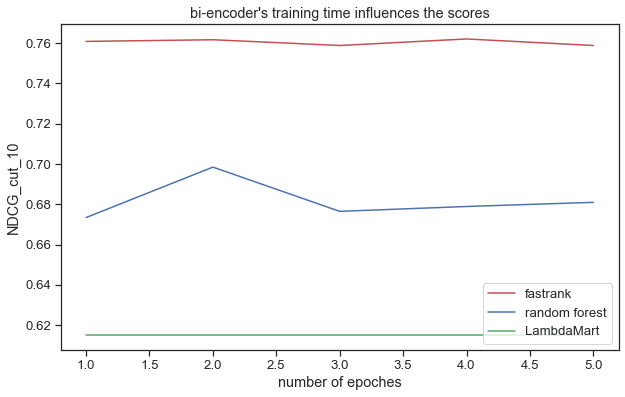

In [31]:
import seaborn as sns
sns.set(rc={"figure.figsize": (10, 6)})
sns.set(style="whitegrid")
sns.set(context='notebook', style='ticks', font_scale=1.2)

ax = sns.lineplot(data = final_re[final_re["L2R models"] == 'fastrank'].reset_index(), x = "epoch", y = "value", color = 'r', label = 'fastrank')
ax = sns.lineplot(data = final_re[final_re["L2R models"] == 'random forest'].reset_index(), x = "epoch", y = "value", color = 'b',label = 'random forest')
ax = sns.lineplot(data = final_re[final_re["L2R models"] == 'LambdaMart'].reset_index(), x = "epoch", y = "value", color = 'g',label = 'LambdaMart')

ax.set_xlabel('number of epoches')
ax.set_ylabel('NDCG_cut_10')
ax.set_title("bi-encoder's training time influences the scores")
ax.legend(loc='lower right')